In [ ]:
# import library
import sys
import numpy as np
import keras.backend as K
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from skimage import io
import traceback
import numpy as np
import numpy.random as npr
from keras.layers import Conv2D
from keras.models import Input, Model
from keras.applications import InceptionResNetV2
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image


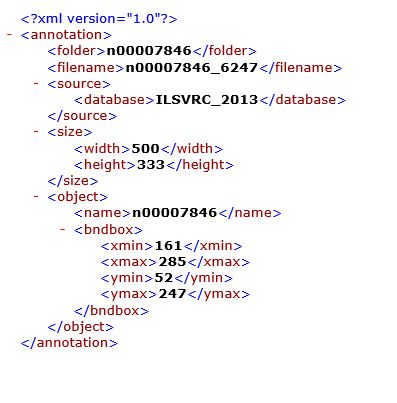

In [32]:
Image("image1.jpg")

In [2]:
# get categorical and bbox, scale from label
def parse_label(xml_file):
    try:
        tree = ET.parse(xml_file)
    except Exception:
        print('Failed to parse: ' + xml_file, file=sys.stderr)
        return None
    root = tree.getroot()
    w_scale=1
    h_scale=1
    width=0
    height=0
    for x in root.iter('width'):
        width=int(x.text)
        if width < 333:
            width=333
            w_scale=333/float(x.text)
    for x in root.iter('height'):
        height==int(x.text)
        if height < 333:
            height=333
            h_scale=333/float(x.text)
    category=[]
    xmin=[]
    ymin=[]
    xmax=[]
    ymax=[]
    for x in root.iter('name'):
        category.append(x.text)
    for x in root.iter('xmin'):
        xmin.append(int(x.text)*w_scale)
    for x in root.iter('ymin'):
        ymin.append(int(x.text)*h_scale)
    for x in root.iter('xmax'):
        xmax.append(int(x.text)*w_scale)
    for x in root.iter('ymax'):
        ymax.append(int(x.text)*h_scale)
    gt_boxes=[list(box) for box in zip(xmin,ymin,xmax,ymax)]
    return category, np.asarray(gt_boxes, np.float), (w_scale, h_scale)

In [3]:
parse_label("n00007846_6247.xml")

(['n00007846'], array([[161.,  52., 285., 247.]]), (1, 1.0))

In [4]:
# classifier loss function
def loss_cls(y_true, y_pred):
    condition = K.not_equal(y_true, -1)
    indices = K.tf.where(condition)
 
    target = K.tf.gather_nd(y_true, indices)
    output = K.tf.gather_nd(y_pred, indices)
    loss = K.binary_crossentropy(target, output)
    return K.mean(loss)

# smooth L1
def smoothL1(y_true, y_pred):
    nd=K.tf.where(K.tf.not_equal(y_true,0))
    y_true=K.tf.gather_nd(y_true,nd)
    y_pred=K.tf.gather_nd(y_pred,nd)
    x = K.tf.losses.huber_loss(y_true,y_pred)
#     x   = K.switch(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
    return x
# draw anchor
def draw_anchors(img_path, anchors, pad_size=50):
    im = Image.open(img_path)
    w,h=im.size
    a4im = Image.new('RGB',
                    (w+2*pad_size, h+2*pad_size),   # A4 at 72dpi
                    (255, 255, 255))  # White
    a4im.paste(im, (pad_size,pad_size))  # Not centered, top-left corner
    for a in anchors:
        a=(a+pad_size).astype(int).tolist()
        draw = ImageDraw.Draw(a4im)
        draw.rectangle(a,outline=(255,0,0), fill=None)
    return a4im

In [5]:
# Generate anchor
def generate_anchors(base_width=16, base_height=16, ratios=[0.5, 1, 2],
                     scales=np.asarray([3,6,12])):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, w_stride-1, h_stride-1) window.
    """

    base_anchor = np.array([1, 1, base_width, base_height]) - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in range(ratio_anchors.shape[0])])
    return anchors#top left botton right

def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

In [6]:
anchors = generate_anchors(base_width=16, base_height=16, ratios=[0.5, 1, 2],
                     scales=np.asarray([3,6,12]))

In [33]:
anchors

array([[ -26.5,  -10. ,   41.5,   25. ],
       [ -61. ,  -28. ,   76. ,   43. ],
       [-130. ,  -64. ,  145. ,   79. ],
       [ -16. ,  -16. ,   31. ,   31. ],
       [ -40. ,  -40. ,   55. ,   55. ],
       [ -88. ,  -88. ,  103. ,  103. ],
       [  -8.5,  -25. ,   23.5,   40. ],
       [ -25. ,  -58. ,   40. ,   73. ],
       [ -58. , -124. ,   73. ,  139. ]])

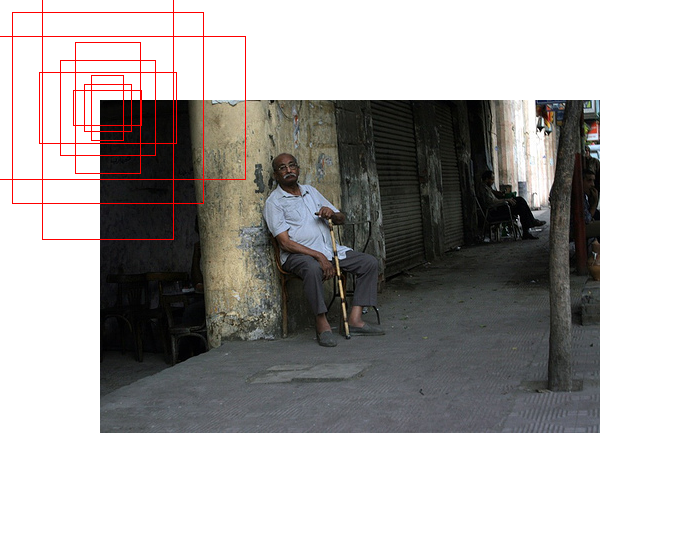

In [7]:
image = io.imread("n00007846_6247.JPEG")
draw_anchors("n00007846_6247.JPEG", anchors, pad_size=100)

In [8]:
width = image.shape[0]
height = image.shape[1]
w_stride = 37 # on image 
h_stride = 35
shift_x = np.arange(0, width) * w_stride
shift_y = np.arange(0, height) * h_stride
shift_x, shift_y = np.meshgrid(shift_x, shift_y)
shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(),
                        shift_y.ravel())).transpose()


In [34]:
shifts[:10]

array([[  0,   0,   0,   0],
       [ 37,   0,  37,   0],
       [ 74,   0,  74,   0],
       [111,   0, 111,   0],
       [148,   0, 148,   0],
       [185,   0, 185,   0],
       [222,   0, 222,   0],
       [259,   0, 259,   0],
       [296,   0, 296,   0],
       [333,   0, 333,   0]])

In [9]:
width = image.shape[0]
height = image.shape[1]
print(width ,height)

333 500


In [10]:
# add A anchors (1, A, 4) to
# cell K shifts (K, 1, 4) to get
# shift anchors (K, A, 4)
# reshape to (K*A, 4) shifted anchors
num_feature_map = width*height
base_anchors = generate_anchors(base_width=16, base_height=16, ratios=[0.5, 1, 2],
                     scales=np.asarray([3,6,12]))
all_anchors = (base_anchors.reshape((1, 9, 4)) +
                    shifts.reshape((1, num_feature_map, 4)).transpose((1, 0, 2)))
total_anchors = num_feature_map*9
all_anchors = all_anchors.reshape((total_anchors, 4))

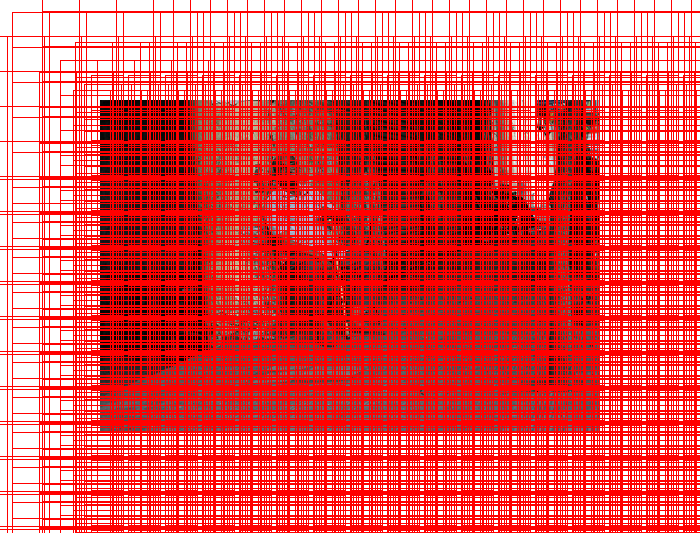

In [11]:
draw_anchors("n00007846_6247.JPEG",all_anchors, pad_size=100)

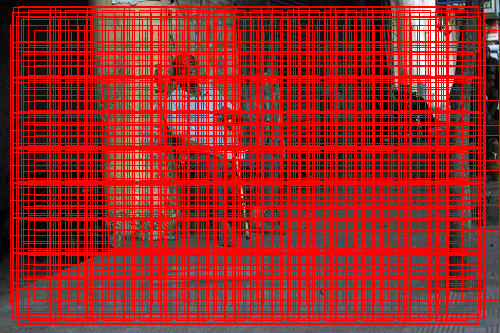

In [12]:
border= 0
inds_inside = np.where(
        (all_anchors[:, 0] >= -border) &
        (all_anchors[:, 1] >= -border) &
        (all_anchors[:, 2] < height+border ) &  # width
        (all_anchors[:, 3] < width+border)    # height
)[0]
anchors_inside =all_anchors[inds_inside]
#anchors_inside = anchors_inside.transpose((1, 0, 2,3))
draw_anchors("n00007846_6247.JPEG",anchors_inside, pad_size=0)

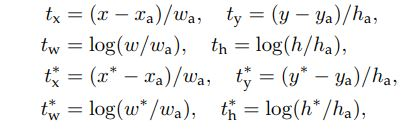

In [35]:
Image("box_tranform.jpg")

In [6]:
def clip_boxes(boxes, im_shape):
    """
    Clip boxes to image boundaries.
    """

    # x1 >= 0
    boxes[:, 0::4] = np.maximum(np.minimum(boxes[:, 0::4], im_shape[1] - 1), 0)
    # y1 >= 0
    boxes[:, 1::4] = np.maximum(np.minimum(boxes[:, 1::4], im_shape[0] - 1), 0)
    # x2 < im_shape[1]
    boxes[:, 2::4] = np.maximum(np.minimum(boxes[:, 2::4], im_shape[1] - 1), 0)
    # y2 < im_shape[0]
    boxes[:, 3::4] = np.maximum(np.minimum(boxes[:, 3::4], im_shape[0] - 1), 0)
    return boxes

def filter_boxes(boxes, min_size):
    """Remove all boxes with any side smaller than min_size."""
    ws = boxes[:, 2] - boxes[:, 0] + 1
    hs = boxes[:, 3] - boxes[:, 1] + 1
    keep = np.where((ws >= min_size) & (hs >= min_size))[0]
    return keep

def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    # dets have shape [x1,x2,y1,y2,scores]
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep


def bbox_transform(ex_rois, gt_rois):
    ex_widths = ex_rois[:, 2] - ex_rois[:, 0] + 1.0
    ex_heights = ex_rois[:, 3] - ex_rois[:, 1] + 1.0
    ex_ctr_x = ex_rois[:, 0] + 0.5 * ex_widths
    ex_ctr_y = ex_rois[:, 1] + 0.5 * ex_heights

    gt_widths = gt_rois[:, 2] - gt_rois[:, 0] + 1.0
    gt_heights = gt_rois[:, 3] - gt_rois[:, 1] + 1.0
    gt_ctr_x = gt_rois[:, 0] + 0.5 * gt_widths
    gt_ctr_y = gt_rois[:, 1] + 0.5 * gt_heights

    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = np.log(gt_widths / ex_widths)
    targets_dh = np.log(gt_heights / ex_heights)

    targets = np.stack((targets_dx, targets_dy, targets_dw, targets_dh))

    targets = np.transpose(targets)

    return targets


def bbox_transform_inv(boxes, deltas):
    if boxes.shape[0] == 0:
        return np.zeros((0, deltas.shape[1]), dtype=deltas.dtype)

    boxes = boxes.astype(deltas.dtype, copy=False)

    widths = boxes[:, 2] - boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights

    dx = deltas[:, 0::4]
    dy = deltas[:, 1::4]
    dw = deltas[:, 2::4]
    dh = deltas[:, 3::4]

    pred_ctr_x = dx * widths[:, np.newaxis] + ctr_x[:, np.newaxis]
    pred_ctr_y = dy * heights[:, np.newaxis] + ctr_y[:, np.newaxis]
    pred_w = np.exp(dw) * widths[:, np.newaxis]
    pred_h = np.exp(dh) * heights[:, np.newaxis]

    pred_boxes = np.zeros(deltas.shape, dtype=deltas.dtype)
    # x1
    pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
    # y1
    pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
    # x2
    pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
    # y2
    pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h

    return pred_boxes

def bbox_overlaps(boxes, query_boxes):
    """
    Parameters
    ----------
    boxes: (N, 4) ndarray of float
    query_boxes: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    boxes=boxes.astype(int)
    N = boxes.shape[0]
    K = query_boxes.shape[0]

    overlaps = np.zeros((N, K), dtype=np.float)

    for k in range(K):
        box_area = ((query_boxes[k, 2] - query_boxes[k, 0] + 1) * (query_boxes[k, 3] - query_boxes[k, 1] + 1))
        for n in range(N):
            iw = (min(boxes[n, 2], query_boxes[k, 2]) - max(boxes[n, 0], query_boxes[k, 0]) + 1)
            if iw > 0:
                ih = (min(boxes[n, 3], query_boxes[k, 3]) - max(boxes[n, 1], query_boxes[k, 1]) + 1)

                if ih > 0:
                    ua = float((boxes[n, 2] - boxes[n, 0] + 1) * (boxes[n, 3] - boxes[n, 1] + 1) + box_area - iw * ih)
                    overlaps[n, k] = iw * ih / ua

    return overlaps

def unmap(data, count, inds, fill=0):##labels, total_anchors, inds_inside
    """ Unmap a subset of item (data) back to the original set of items (of
    size count) """
    if len(data.shape) == 1:
        ret = np.empty((count, ), dtype=np.float32)
        ret.fill(fill)
        ret[inds] = data
    else:
        ret = np.empty((count, ) + data.shape[1:], dtype=np.float32)
        ret.fill(fill)
        ret[inds, :] = data
    return ret

In [14]:
#labels, 1=fg/0=bg/-1=ignore
BG_FG_FRAC=2

def produce_batch(filepath, gt_boxes, scale):
    img=load_img(filepath)
    img_width=np.shape(img)[1] * scale[1] ## scale image 
    img_height=np.shape(img)[0] * scale[0]
    img=img.resize((int(img_width),int(img_height)))
    #feed image to pretrained model and get feature map
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)# add 1 dim
    feature_map=pretrained_model.predict(img) # take feature map
    height = np.shape(feature_map)[1]
    width = np.shape(feature_map)[2]
    num_feature_map=width*height
    #calculate output w, h stride
    w_stride = img_width / width # caculate scale 
    h_stride = img_height / height
    #generate base anchors according output stride.
    #base anchors are 9 anchors wrt a tile (0,0,w_stride-1,h_stride-1)
    base_anchors=generate_anchors(w_stride,h_stride)
    #slice tiles according to image size and stride.
    #each 1x1x1532 feature map is mapping to a tile.
    shift_x = np.arange(0, width) * w_stride
    shift_y = np.arange(0, height) * h_stride
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(),
                            shift_y.ravel())).transpose()
    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    #apply base anchors to all tiles, to have a num_feature_map*9 anchors.
    all_anchors = (base_anchors.reshape((1, 9, 4)) +
                    shifts.reshape((1, num_feature_map, 4)).transpose((1, 0, 2)))# shape (126,9,4)
    total_anchors = num_feature_map*9
    all_anchors = all_anchors.reshape((total_anchors, 4))# reshape (126*9,4)
    #only keep anchors inside image+borader.
    border=0
    inds_inside = np.where(
            (all_anchors[:, 0] >= -border) &
            (all_anchors[:, 1] >= -border) &
            (all_anchors[:, 2] < img_height + border ) &  # width
            (all_anchors[:, 3] < img_width + border)    # height
    )[0]
    anchors=all_anchors[inds_inside]
    # calculate overlaps each anchors to each gt boxes,
    # a matrix with shape [len(anchors) x len(gt_boxes)]
    overlaps = bbox_overlaps(anchors, gt_boxes)# calculate overlap anchor inside with grouth truth
    # find the gt box with biggest overlap to each anchors,
    # and the overlap ratio. result (len(anchors),)
    argmax_overlaps = overlaps.argmax(axis=1)## take max of each query
    max_overlaps = overlaps[np.arange(len(inds_inside)), argmax_overlaps]# take overlap max query
    # find the anchor with biggest overlap to each gt boxes,
    # and the overlap ratio. result (len(gt_boxes),)
    gt_argmax_overlaps = overlaps.argmax(axis=0)# take max of each proposal
    gt_max_overlaps = overlaps[gt_argmax_overlaps,
                                np.arange(overlaps.shape[1])]# take overlap max anchor
    gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0] # take index query max
    #labels, 1=fg/0=bg/-1=ignore
    labels = np.empty((len(inds_inside), ), dtype=np.float32)# create label 
    labels.fill(-1)
    # set positive label, define in Paper3.1.2:
    # We assign a positive label to two kinds of anchors: (i) the
    # anchor/anchors with the highest Intersection-overUnion
    # (IoU) overlap with a ground-truth box, or (ii) an
    # anchor that has an IoU overlap higher than 0.7 with any gt boxes
    labels[gt_argmax_overlaps] = 1
    labels[max_overlaps >= .7] = 1
    # set negative labels
    labels[max_overlaps <= .3] = 0
    # subsample positive labels if we have too many
#     num_fg = int(RPN_FG_FRACTION * RPN_BATCHSIZE)
    fg_inds = np.where(labels == 1)[0]
#     if len(fg_inds) > num_fg:
#         disable_inds = npr.choice(
#             fg_inds, size=(len(fg_inds) - num_fg), replace=False)
#         labels[disable_inds] = -1
    # subsample negative labels if we have too many
    num_bg = int(len(fg_inds) * BG_FG_FRAC)
    bg_inds = np.where(labels == 0)[0]
    if len(bg_inds) > num_bg:
        disable_inds = npr.choice(
            bg_inds, size=(len(bg_inds) - num_bg), replace=False)
        labels[disable_inds] = -1
    #
    batch_inds=inds_inside[labels!=-1]
    batch_inds=(batch_inds / k).astype(np.int)
    full_labels = unmap(labels, total_anchors, inds_inside, fill=-1)
    batch_label_targets=full_labels.reshape(-1,1,1,1*k)[batch_inds]# 1
    bbox_targets = np.zeros((len(inds_inside), 4), dtype=np.float32)
    # bbox_targets = bbox_transform(anchors, gt_boxes[argmax_overlaps, :]
    pos_anchors=all_anchors[inds_inside[labels==1]]
    bbox_targets = bbox_transform(pos_anchors, gt_boxes[argmax_overlaps, :][labels==1])
    bbox_targets = unmap(bbox_targets, total_anchors, inds_inside[labels==1], fill=0)
    batch_bbox_targets = bbox_targets.reshape(-1,1,1,4*k)[batch_inds]
    padded_fcmap=np.pad(feature_map,((0,0),(1,1),(1,1),(0,0)),mode='constant')
    padded_fcmap=np.squeeze(padded_fcmap)
    batch_tiles=[]
    for ind in batch_inds:
        x = ind % width
        y = int(ind/width)
        fc_3x3=padded_fcmap[y:y+3,x:x+3,:]
        batch_tiles.append(fc_3x3)
    return np.asarray(batch_tiles), batch_label_targets.tolist(), batch_bbox_targets.tolist()

In [15]:
#load an example to void graph problem
#TODO fix this.
pretrained_model = InceptionResNetV2(include_top=False)
img=load_img("./ILSVRC2014_train_00010391.JPEG")
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
not_used=pretrained_model.predict(x)
not_used.shape

(1, 9, 14, 1536)

In [7]:
k=9 #anchor number for each point
##################  RPN Model  #######################
feature_map_tile = Input(shape=(None,None,1536))
convolution_3x3 = Conv2D(
    filters=512,
    kernel_size=(3, 3),
    padding='same',
    name="3x3"
)(feature_map_tile)

output_deltas = Conv2D(
    filters= 4 * k,
    kernel_size=(1, 1),
    activation="linear",
    kernel_initializer="uniform",
    name="deltas1"
)(convolution_3x3)

output_scores = Conv2D(
    filters=1 * k,
    kernel_size=(1, 1),
    activation="sigmoid",
    kernel_initializer="uniform",
    name="scores1"
)(convolution_3x3)

model = Model(inputs=[feature_map_tile], outputs=[output_scores, output_deltas])
model.compile(optimizer='adam', loss={'scores1':loss_cls, 'deltas1':smoothL1})


In [ ]:
ILSVRC_dataset_path='/ILSVRC/'
img_path=ILSVRC_dataset_path+'Data/DET/train/'
anno_path=ILSVRC_dataset_path+'/Annotations/DET/train/'
import glob

BATCH_SIZE= 256
def input_generator():
    batch_tiles=[]
    batch_labels=[]
    batch_bboxes=[]
    count=0
    while 1:
        for fname in glob.glob(ILSVRC_dataset_path+'/ImageSets/DET/train_*')[:1]:
            with open(fname,'r') as f:
                for line in f:
                    if 'extra' not in line:
                        try:
                            category, gt_boxes, scale = parse_label(anno_path+line.split()[0]+'.xml')
                            if len(gt_boxes)==0:
                                continue
                            tiles, labels, bboxes = produce_batch(img_path+line.split()[0]+'.JPEG', gt_boxes, scale)
                        except Exception:
                            #print('parse label or produce batch failed: for: '+ line.split()[0])
                            #traceback.print_exc()
                            continue
                        for i in range(len(tiles)):
                            batch_tiles.append(tiles[i])
                            batch_labels.append(labels[i])
                            batch_bboxes.append(bboxes[i])
                            if(len(batch_tiles)==BATCH_SIZE):
                                a=np.asarray(batch_tiles)
                                b=np.asarray(batch_labels)
                                c=np.asarray(batch_bboxes)
                                if not a.any() or not b.any() or not c.any():
                                    print("empty array found.")

                                yield a, [b, c]
                                batch_tiles=[]
                                batch_labels=[]
                                batch_bboxes=[]
##################   start train   #######################
#(features, labels, batch_size)
from keras.callbacks import ModelCheckpoint
#checkpointer = ModelCheckpoint(filepath='./weights.hdf5', verbose=1, save_best_only=True)callbacks=[checkpointer]
model.fit_generator(input_generator(), steps_per_epoch=10, epochs=10 )

Epoch 1/10


In [19]:
ILSVRC_dataset_path='/ILSVRC/'
img_path=ILSVRC_dataset_path+'Data/DET/train/'
anno_path=ILSVRC_dataset_path+'/Annotations/DET/train/'
import glob

In [21]:
for layer in model.layers :
    print(layer.get_output_at(0).get_shape().as_list())

[None, None, None, 1536]
[None, None, None, 512]
[None, None, None, 9]
[None, None, None, 36]


In [22]:
for l in model.layers:
    print (l.output_shape)

(None, None, None, 1536)
(None, None, None, 512)
(None, None, None, 9)
(None, None, None, 36)


In [23]:
img=load_img("./ILSVRC2014_train_00010391.JPEG")

In [24]:
category, gt_boxes, scale = parse_label("n00007846_6247.xml")
img=load_img("./ILSVRC2014_train_00010391.JPEG")
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
not_used=pretrained_model.predict(x)
pre = model.predict(not_used)

In [36]:
print(not_used.shape)
img_width=np.shape(img)[1] * scale[1] 
img_height=np.shape(img)[0] * scale[0]

(1, 9, 14, 1536)


In [37]:
print("image width",img_width)
print("image height",img_height)

image width 500.0
image height 333


In [38]:
img=img.resize((int(img_width),int(img_height)))
height = np.shape(not_used)[1]
width = np.shape(not_used)[2]
print("height",height)
print("width",width)

height 9
width 14


In [41]:
num_feature_map=width*height
print("number feature map :",num_feature_map)
w_stride = img_width / width # caculate scale 
h_stride = img_height / height
print("w stride :",int(w_stride))
print("h stride :",int(h_stride))

number feature map : 126
w stride : 35
h stride : 37


In [42]:
base_anchors=generate_anchors(w_stride,h_stride)
print("shape base anchor :",base_anchors.shape)

shape base anchor : (9, 4)


In [44]:
shift_x = np.arange(0, width) * w_stride
shift_y = np.arange(0, height) * h_stride
shift_x, shift_y = np.meshgrid(shift_x, shift_y)
shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(),
                        shift_y.ravel())).transpose()
all_anchors = (base_anchors.reshape((1, 9, 4)) +
                    shifts.reshape((1, num_feature_map, 4)).transpose((1, 0, 2)))
total_anchors = num_feature_map*9
all_anchors = all_anchors.reshape((total_anchors, 4))

In [45]:
overlaps = bbox_overlaps(anchors, gt_boxes)

In [46]:
np.array(overlaps).shape

(9, 1)

In [ ]:
import tensorflow as

In [ ]:
c